In [1]:
import torch
from datasets import ALOVDataset, ILSVRC2014_DET_Dataset
from torchvision import transforms
from helper import *
import argparse
import numpy as np

In [2]:
use_gpu = torch.cuda.is_available()
kSaveModel = 20000 # save model after every 20000 steps
kGeneratedExamplesPerImage = 10; # generate 10 synthetic samples per image in a dataset
transform = transforms.Compose([Normalize(), ToTensor()])

In [3]:
alov = ALOVDataset('../data/alov300/imagedata++/',
                   '../data/alov300/alov300++_rectangleAnnotation_full/',
                   transform)

Parsing ALOV dataset...
ALOV dataset parsing done.
Total number of annotations in ALOV Dataset = 16023


In [4]:
lambda_shift_frac = 5
lambda_scale_frac = 15
min_scale = -0.4
max_scale = 0.4
imagenet = ILSVRC2014_DET_Dataset('../data/imagenet_img/',
                                   '../data/imagenet_bbox/',
                                   transform,
                                   lambda_shift_frac,
                                   lambda_scale_frac,
                                   min_scale,
                                   max_scale)

Parsing ImageNet dataset...
ImageNet dataset parsing done.
Total number of annotations in ImageNet Dataset = 2323


In [5]:
def make_numpy_samples(dataset, args):
    
    idx = np.random.randint(dataset.len, size=1)[0]
    orig_sample = dataset.get_orig_sample(idx) # unscaled original sample (single image and bb)
    true_sample = dataset.get_sample(idx) # cropped scaled sample (two frames and bb)
#     true_tensor = transform(true_sample)

    origimg = orig_sample['image']
    origbb = orig_sample['bb']
    x1_batch = np.zeros((kGeneratedExamplesPerImage + 1, 227, 227, 3))
    x2_batch = np.zeros((kGeneratedExamplesPerImage + 1, 227, 227, 3))
    y_batch = np.zeros((kGeneratedExamplesPerImage + 1, 4))

    # initialize batch with the true sample
    x1_batch[0,:,:,:] = true_sample['previmg']
    x2_batch[0,:,:,:] = true_sample['currimg']
    y_batch[0,:] = true_sample['currbb']

    for i in range(kGeneratedExamplesPerImage):
        sample = {'image': origimg, 'bb': origbb}
        prevbb = random_crop(sample,
                             lambda_scale_frac,
                             lambda_shift_frac,
                             min_scale,
                             max_scale)

        # Crop previous image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        crop_curr = transforms.Compose([CropCurr()])
        scale = Rescale((227,227))
        transform_prev = transforms.Compose([CropPrev(), scale])
        prev_img = transform_prev({'image':origimg, 'bb':origbb})['image']
        # Crop current image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        curr_obj = crop_curr({'image':origimg, 'prevbb':prevbb, 'currbb':origbb})
        curr_obj = scale(curr_obj)
        curr_img = curr_obj['image']
        currbb = curr_obj['bb']
        currbb = np.array(currbb)
        sample = {'previmg': prev_img,
                'currimg': curr_img,
                'currbb' : currbb
                }
        x1_batch[i+1,:,:,:] = sample['previmg']
        x2_batch[i+1,:,:,:] = sample['currimg']
        y_batch[i+1,:] = sample['currbb']
    return x1_batch, x2_batch, y_batch

In [6]:
x1, x2, y = make_numpy_samples(alov, None)

In [7]:
def make_tensor_samples(dataset, args):
    transform = transforms.Compose([ToTensor()])
    idx = np.random.randint(dataset.len, size=1)[0]
    orig_sample = dataset.get_orig_sample(idx) # unscaled original sample (single image and bb)
    true_sample = dataset.get_sample(idx) # cropped scaled sample (two frames and bb)
    true_tensor = transform(true_sample)

    origimg = orig_sample['image']
    origbb = orig_sample['bb']
    x1_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 3, 227, 227)
    x2_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 3, 227, 227)
    y_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 4)

    # initialize batch with the true sample
    x1_batch[0,:,:,:] = true_tensor['previmg']
    x2_batch[0,:,:,:] = true_tensor['currimg']
    y_batch[0,:] = true_tensor['currbb']

    for i in range(kGeneratedExamplesPerImage):
        sample = {'image': origimg, 'bb': origbb}
        prevbb = random_crop(sample,
                             lambda_scale_frac,
                             lambda_shift_frac,
                             min_scale,
                             max_scale)

        # Crop previous image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        crop_curr = transforms.Compose([CropCurr()])
        scale = Rescale((227,227))
        transform_prev = transforms.Compose([CropPrev(), scale])
        prev_img = transform_prev({'image':origimg, 'bb':origbb})['image']
        # Crop current image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        curr_obj = crop_curr({'image':origimg, 'prevbb':prevbb, 'currbb':origbb})
        curr_obj = scale(curr_obj)
        curr_img = curr_obj['image']
        currbb = curr_obj['bb']
        currbb = np.array(currbb)
        sample = {'previmg': prev_img,
                'currimg': curr_img,
                'currbb' : currbb
                }
        sample = transform(sample)
        x1_batch[i+1,:,:,:] = sample['previmg']
        x2_batch[i+1,:,:,:] = sample['currimg']
        y_batch[i+1,:] = sample['currbb']

    return {'previmg': x1_batch, 'currimg': x2_batch, 'currbb': y_batch}

In [8]:
batch = make_tensor_samples(alov, None)

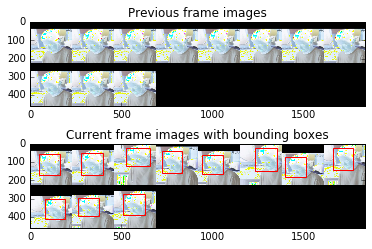

In [9]:
batch['previmg'].size()
show_batch(batch)

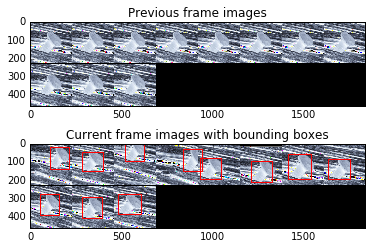

In [10]:
batch = make_tensor_samples(imagenet, None)
show_batch(batch)